In [11]:
# -*- coding: utf-8 -*-
"""
This script runs the multi GAN and allows you to step through each part
# divide y by exposure in xpxixpy
"""

# import modules
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import argparse
import torch

import numpy as np

## Import created modules
from Functions.MC_WGAN_GP.gan_scripts.auto_loader import PolicyDataset
from Functions.MC_WGAN_GP.gan_scripts.generator2_v2 import Generator2
from Functions.MC_WGAN_GP.gan_scripts.discriminator2_v3 import Discriminator2
from Functions.MC_WGAN_GP.gan_scripts.gradiant_penalty import calculate_gradient_penalty
from Functions.MC_WGAN_GP.gan_scripts.undo_dummy import back_from_dummies

from torch.autograd.variable import Variable
from torch.optim import Adam


%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


False

In [19]:
train = pd.read_pickle("./data/gan_dataprep/train_gan.pickle")
val = pd.read_pickle("./data/gan_dataprep/val_gan.pickle")

In [21]:
train.head(2).transpose()

,0,1
VehPower,-0.71,-0.71
VehAge,-1.29,-1.29
DrivAge,0.67,0.67
DensityGLM,0.60,0.60
BonusMalus,-0.62,-0.62
Exposure,-1.18,0.66
ClaimNb_0.0,-4.35,-4.35
ClaimNb_1.0,4.48,4.48
ClaimNb_2.0,-0.05,-0.05
ClaimNb_3.0,-0.01,-0.01


In [13]:
len(train)

487648

In [14]:
pol_dat = train

In [15]:
formula = 'ClaimNb ~ VehBrand + VehGas + Region + AreaGLM + VehPower + VehAge + DrivAge + DensityGLM + BonusMalus'

In [16]:
# Wrangle train data
td = back_from_dummies(train)
td['ClaimNb'] = td['ClaimNb'].astype('float').astype('int')
y_real, X_real = dmatrices(formula,
                 data=td,
                 return_type='dataframe')
def xpxixpy(X,y):
            return np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,y))
xy = xpxixpy(X_real,y_real)
disc_add_rows = xy.shape[0]

# Fit a poisson Model
poisson_mod = sm.GLM(y_real,X_real,family = sm.families.Poisson(), offset = td['Exposure']).fit()
original_params = poisson_mod.params

lower = poisson_mod.params - 1.96*poisson_mod.bse  
upper = poisson_mod.params + 1.96*poisson_mod.bse 

# Wrangle Test Data
test2 = back_from_dummies(val)
test2['ClaimNb'] = test2['ClaimNb'].astype('float').astype('int')
y_test, X_test = dmatrices(formula,
                 data=test2,
                 return_type='dataframe')
y_test_resp = np.squeeze(y_test)/np.squeeze(test2['Exposure'])

# make predictions on test data with models trained on train data
real_pois_preds = poisson_mod.predict(X_test)

In [17]:
"""
This next section contains everything that we can tune in the GAN
"""

# Information about the size of the data
data_size = pol_dat.shape[1] # number of cols in pol_dat 
var_locs = [0,1,2,3,4,5] # tells us where the continous variables are 


# parameters
z_size = 100 # how big is the random vector fed into the generator
# we should only need the 55?
batch_size = 1500
temperature = None # comes into play with the categorical activation see multioutput.py

# Generator tuning
gen_hidden_sizes = [100,100,100]
gen_bn_decay = .25
gen_l2_regularization = 0.1
gen_learning_rate = 0.001
noise_size = z_size
output_size = [1,1,1,1,1,1,5,11,2,22,6]  # how many categories with in each variable

assert sum(output_size) == data_size

# Discriminator tuning
disc_hidden_sizes = [data_size,data_size]
disc_bn_decay = .2
critic_bool = True # if false then between 0 and 1
mini_batch_bool = False
disc_leaky_param = 0.2
disc_l2_regularization = 0.0
disc_learning_rate = 0.001
penalty = 1 ## deals with gradiant penalty

auto_data = PolicyDataset(pol_dat, var_locs)
auto_loader = DataLoader(auto_data,
                         batch_size = batch_size,
                         pin_memory = True, 
                         shuffle = True
                         )

# initilize generator and discriminator
generator = Generator2(
    noise_size = noise_size,
    output_size =  output_size,
    hidden_sizes = gen_hidden_sizes,
    bn_decay = gen_bn_decay
    )

discriminator = Discriminator2(
    input_size = data_size,
    hidden_sizes= disc_hidden_sizes,
    bn_decay = disc_bn_decay,               # no batch normalization for the critic
    critic = critic_bool,                   # Do you want a critic
    leaky_param = disc_leaky_param,         # parameter for leakyRelu
    mini_batch = mini_batch_bool,           # Do you want any mini batch extras
    add_rows = disc_add_rows # Number of rows to add if appending extra rows 
    )


optim_gen = optim.Adam(generator.parameters(),
                       weight_decay= gen_l2_regularization,
                       lr= gen_learning_rate
                       )

optim_disc = optim.Adam(discriminator.parameters(),
                        weight_decay= disc_l2_regularization,
                        lr= disc_learning_rate
                        )    

epochs = 500
disc_epochs = 2
gen_epochs = 1
generator.train(mode=True)
discriminator.train(mode=True)
disc_losses = []
gen_losses = []
pois_metric = []

epoch:0, disc_loss:-6.9494, gen_loss:-2.8892:   0%|          | 1/500 [01:01<8:33:32, 61.75s/it]  /Users/janjaniszewski/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
epoch:20, disc_loss:-18.4441, gen_loss:-10.8992:   4%|▍         | 21/500 [27:00<10:21:36, 77.86s/it] /Users/janjaniszewski/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
epoch:40, disc_loss:580.2442, gen_loss:-36.0383:   8%|▊         | 41/500 [52:04<9:54:04, 77.66s/it]  /Users/janjaniszewski/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
epoch:60, disc_loss:-31.7920, gen_loss:-95.0877:  12%|█▏        | 61/500 [1:14:09<7:31:15, 61.68s/it]  /Users/jan

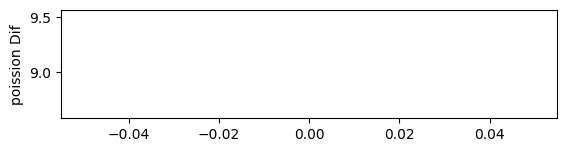

Mean Absolute Difference Pois: 9.07


NameError: name 'y_gen2' is not defined

<Figure size 640x480 with 0 Axes>

In [18]:
disc_loss = torch.tensor(9999)
gen_loss = torch.tensor(9999)
loop = tqdm(total = epochs, position = 0, leave = False)
for epoch in range(epochs):
    for d_epoch in range(disc_epochs):  
        for c1,c2 in auto_loader: # c1 is continous variables and c2 is the categorical variables
            batch = torch.cat([c2,c1],1) 
            optim_disc.zero_grad()
            
            # train discriminator with real data
            real_features = Variable(batch)
            real_pred = discriminator(real_features)
            # the disc outputs high numbers if it thinks the data is real, we take the negative of this
            # Because we are minimizing loss
            real_loss = -real_pred.mean(0).view(1)  
            real_loss.backward()

            # then train the discriminator only with fake data
            noise = Variable(torch.FloatTensor(len(batch), z_size).normal_())
            fake_features = generator(noise, training = True)
            fake_features = fake_features.detach()  # do not propagate to the generator
            fake_pred = discriminator(fake_features)
            fake_loss = fake_pred.mean(0).view(1)
            fake_loss.backward()
            
            # this is the magic from WGAN-GP
            gradient_penalty = calculate_gradient_penalty(discriminator, penalty, real_features, fake_features)
            gradient_penalty.backward()

            # finally update the discriminator weights
            optim_disc.step()

            disc_loss = real_loss + fake_loss + gradient_penalty
            disc_losses = disc_loss.item()
            # Delete to prevent memory leakage
            del gradient_penalty
            del fake_loss
            del real_loss
            del disc_loss
            del real_features
            del real_pred
            del noise
            del fake_features
            del fake_pred
    

    for g_epoch in range(gen_epochs):
        optim_gen.zero_grad()

        noise = Variable(torch.FloatTensor(len(batch), z_size).normal_())
        gen_features = generator(noise)
        gen_pred = discriminator(gen_features)

        gen_loss = - gen_pred.mean(0).view(1)
        gen_loss.backward()

        optim_gen.step()

        gen_loss = gen_loss
        gen_losses = gen_loss.item()
        del gen_loss 
        del noise
        del gen_features
        del gen_pred
            
    loop.set_description('epoch:{}, disc_loss:{:.4f}, gen_loss:{:.4f}'.format(epoch, disc_losses, gen_losses))
    loop.update(1) 
    # analyze poisson regression parameters every 20 epochs
    if(epoch % 20 == 0):
        with torch.no_grad():
            generated_data = generator(Variable(torch.FloatTensor(pol_dat.shape[0], z_size).normal_()), training = False)
        df1 = pd.DataFrame(generated_data.data.numpy())
        df1.columns = list(pol_dat)
        df2 = back_from_dummies(df1)
        df2['ClaimNb'] = df2['ClaimNb'].astype('float').astype('int')
        y_gen, X_gen = dmatrices(formula,
                             data=df2,
                             return_type='dataframe')
        
        #df2.to_csv(output_data_save_path)
        # Fit poisson Model
        try:
            poisson_mod_gen = sm.GLM(y_gen,X_gen,family = sm.families.Poisson(), offset = np.log(df2['Exposure'])).fit()
        except ValueError:
            continue
        # Calculate Errors
        errors_pois = poisson_mod_gen.predict(X_test) - real_pois_preds
        
        pois_metric.append(round(np.mean(errors_pois), 4))
        
        if(epoch > 3) :
            plt.subplot(311)
            plt.plot(pois_metric, label = 'train')
            plt.ylabel('poission Dif')
            plt.show()
            plt.clf()
        
        print('Mean Absolute Difference Pois:', round(np.mean(errors_pois), 2))
        
        del errors_pois
        del poisson_mod_gen
        del importances_gen
        del gen_predictions 
        del generated_data
        del df1
        del df2
        del gen_features
        
        
        torch.save(generator.state_dict(), f='./saved_parameters/gen_test')
        print(pois_df)

      


False